In [25]:
from os import chmod

import numpy as np
import pandas as pd
from exceptiongroup import print_exc
from scipy.stats import truncnorm, norm
from six import print_


# Conditional skills
def conditional_skills(mu_s1, mu_s2, sigma_s1, sigma_s2, t, outcome_var):
    mean_s = np.array([mu_s1, mu_s2])
    cov_s = np.array([[sigma_s1, 0],
                      [0, sigma_s2]])  # Covariance matrix with S_12 and S_21
    outcome_mean = mu_s1 - mu_s2
    outcome_var = sigma_s1 + sigma_s2 + outcome_var # Outcome variance

    # Conditional mean update
    mean_cond = mean_s + (t - outcome_mean) / outcome_var * np.array([sigma_s1, -sigma_s2])

    # Conditional covariance update
    cov_cond = cov_s - np.outer([sigma_s1, -sigma_s2], [sigma_s1, -sigma_s2]) / outcome_var
  
    return mean_cond, cov_cond


# Conditional outcome (truncated Gaussian)
def conditional_outcome(mu_s1, mu_s2, result, outcome_var): #changed so that it only depends on mu_s1 and mu_s2
    mean_diff = mu_s1 - mu_s2
    std_diff = outcome_var

    # Set truncation limits based on match outcome
    if result == 1:
        a, b = 0, np.inf  # Truncate for team 1 winning
    else:
        a, b = -np.inf, 0  # Truncate for team 2 winning

    # Create truncated Gaussian distribution
    trunc_gauss_dist = truncnorm(a=(a - mean_diff) / std_diff, b=(b - mean_diff) / std_diff, loc=mean_diff, scale=std_diff)
    
    return a,b



# Marginal probability that team 1 wins
def marginal_p_y1(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t):
    mu_diff = mu_s1 - mu_s2
    sigma_diff = np.sqrt(sigma_s1 + sigma_s2 + sigma_t)
    p_y1 = 1 - norm.cdf(0, loc=mu_diff, scale=sigma_diff)
    return p_y1

#print("marginal_y =", marginal_p_y1(1, -1, 1, 4,5)) #Probability p(t > 0), e.g player 1 wins. Where t is the Gaussian random variable obtained by marginalizing out s1 and s2 from p(t, s1, s2).


#Gibbs sampler

def gibbs_sampler(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter):
    s1_samples = np.zeros(n_iter)
    s2_samples = np.zeros(n_iter)
    t_samples = np.zeros(n_iter)
    y_samples = np.zeros(n_iter)
    s1, s2 = mu_s1, mu_s2
    
    #initializing the truncation limits
    a, b = conditional_outcome(s1, s2, 1, sigma_t)
    t = truncnorm.rvs(a, b, loc=s1 - s2, scale= sigma_t)
    
    for i in range(n_iter):
        y = 1 
        mean_cond, cov_cond = conditional_skills(mu_s1, mu_s2,sigma_s1, sigma_s2, t, sigma_t) # P(s1, s2 | t)
        s1, s2 = np.random.multivariate_normal(mean_cond, cov_cond)
        s1_samples[i] = s1
        s2_samples[i] = s2
        a, b = conditional_outcome(s1, s2, y, sigma_t)
        t = truncnorm.rvs(a, b, loc=s1 - s2, scale= sigma_t) #P(t | s1, s2 ,y)
        t_samples[i] = t
        y_samples[i] = y

    return s1_samples, s2_samples, t_samples

n_iter = 100 
mu_s1 = 25 # Initial mean for player 1
mu_s2 = 25 # Initial mean for player 2
sigma_s1 = 8.33 # Variance for player 1
sigma_s2 = 8.33 # Variance for player 2
sigma_t = 25/6 # Outcome variance

s1_samples, s2_samples, t_samples = gibbs_sampler(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter)

# Step 1: Calculate the means
mean_s1 = np.mean(s1_samples)
mean_s2 = np.mean(s2_samples)
mean_t = np.mean(t_samples)

# Step 2: Calculate the variances
var_s1 = np.var(s1_samples, ddof=1)
var_s2 = np.var(s2_samples, ddof=1)
var_t = np.var(t_samples, ddof=1)

    
        
            

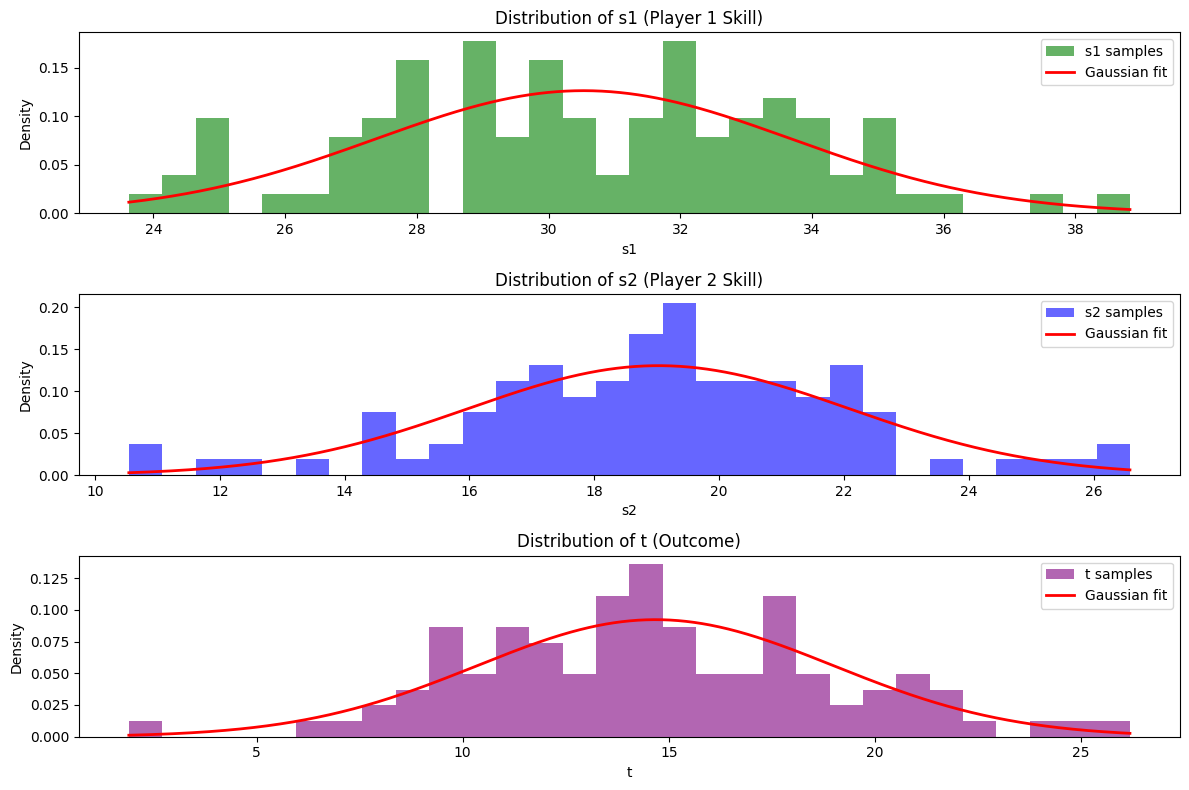

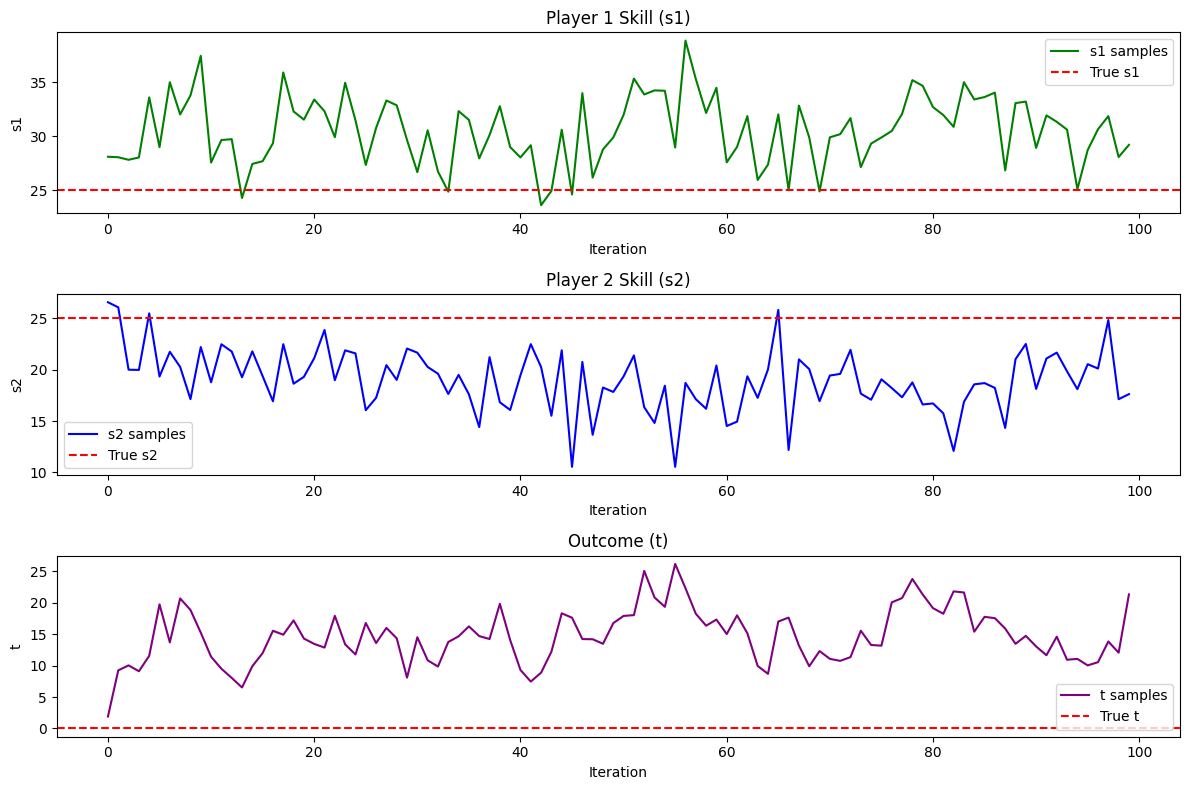

In [26]:
# Plot the samples
import matplotlib.pyplot as plt


# Step 3: Plot the histograms with fitted Gaussian curves
x_s1 = np.linspace(min(s1_samples), max(s1_samples), 1000)
x_s2 = np.linspace(min(s2_samples), max(s2_samples), 1000)
x_t = np.linspace(min(t_samples), max(t_samples), 1000)

# Plot s1 samples
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.hist(s1_samples, bins=30, density=True, alpha=0.6, color='g', label="s1 samples")
plt.plot(x_s1, norm.pdf(x_s1, mean_s1, np.sqrt(var_s1)), 'r-', lw=2, label="Gaussian fit")
plt.title('Distribution of s1 (Player 1 Skill)')
plt.xlabel('s1')
plt.ylabel('Density')
plt.legend()

# Plot s2 samples
plt.subplot(3, 1, 2)
plt.hist(s2_samples, bins=30, density=True, alpha=0.6, color='b', label="s2 samples")
plt.plot(x_s2, norm.pdf(x_s2, mean_s2, np.sqrt(var_s2)), 'r-', lw=2, label="Gaussian fit")
plt.title('Distribution of s2 (Player 2 Skill)')
plt.xlabel('s2')
plt.ylabel('Density')
plt.legend()

# Plot t samples
plt.subplot(3, 1, 3)
plt.hist(t_samples, bins=30, density=True, alpha=0.6, color='purple', label="t samples")
plt.plot(x_t, norm.pdf(x_t, mean_t, np.sqrt(var_t)), 'r-', lw=2, label="Gaussian fit")
plt.title('Distribution of t (Outcome)')
plt.xlabel('t')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(s1_samples, color='g', label="s1 samples")
plt.axhline(y=mu_s1, color='r', linestyle='--', label="True s1")
plt.title('Player 1 Skill (s1)')
plt.xlabel('Iteration')
plt.ylabel('s1')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(s2_samples, color='b', label="s2 samples")
plt.axhline(y=mu_s2, color='r', linestyle='--', label="True s2")
plt.title('Player 2 Skill (s2)')
plt.xlabel('Iteration')
plt.ylabel('s2')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_samples, color='purple', label="t samples")
plt.axhline(y=mu_s1 - mu_s2, color='r', linestyle='--', label="True t")
plt.title('Outcome (t)')
plt.xlabel('Iteration')
plt.ylabel('t')
plt.legend()

plt.tight_layout()

plt.show()

In [27]:
def gibbs_sampler_result(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter, result):
    s1_samples = np.zeros(n_iter)
    s2_samples = np.zeros(n_iter)
    t_samples = np.zeros(n_iter)
    y_samples = np.zeros(n_iter)
    s1, s2 = mu_s1, mu_s2

    #initializing the truncation limits
    a, b = conditional_outcome(s1, s2, 1, sigma_t)
    t = truncnorm.rvs(a, b, loc=s1 - s2, scale= sigma_t)

    for i in range(n_iter):
        y = result 
        mean_cond, cov_cond = conditional_skills(mu_s1, mu_s2,sigma_s1, sigma_s2, t, sigma_t) # P(s1, s2 | t)
        s1, s2 = np.random.multivariate_normal(mean_cond, cov_cond)
        s1_samples[i] = s1
        s2_samples[i] = s2
        a, b = conditional_outcome(s1, s2, y, sigma_t)
        t = truncnorm.rvs(a, b, loc=s1 - s2, scale= sigma_t) #P(t | s1, s2 ,y)
        t_samples[i] = t
        y_samples[i] = y

    return s1_samples, s2_samples, t_samples

In [28]:
import pandas as pd

# Load the CSV data into a pandas DataFrame
data = 'SerieA.csv'
df = pd.read_csv(data)

# Filter out matches where the score is a draw
df_filtered = df[df['score1'] != df['score2']].copy()  # Use .copy() to avoid the warning

# Create a new 'win' column: 1 if Team 1 won, -1 if Team 1 lost
df_filtered.loc[:, 'win'] = df_filtered.apply(lambda row: 1 if row['score1'] > row['score2'] else -1, axis=1)

# Display the filtered DataFrame with the 'win' column



In [29]:

print(df_filtered)


     yyyy-mm-dd  HH:MM     team1     team2  score1  score2  win
0    2018-08-18  18:00    Chievo  Juventus       2       3   -1
1    2018-08-18  20:30     Lazio    Napoli       1       2   -1
2    2018-08-19  18:00    Torino      Roma       0       1   -1
3    2018-08-19  20:30  Sassuolo     Inter       1       0    1
5    2018-08-19  20:30    Empoli  Cagliari       2       0    1
..          ...    ...       ...       ...     ...     ...  ...
374  2019-05-26  20:30      Spal     Milan       2       3   -1
375  2019-05-26  20:30      Roma     Parma       2       1    1
376  2019-05-26  20:30     Inter    Empoli       2       1    1
378  2019-05-26  20:30  Cagliari   Udinese       1       2   -1
379  2019-05-26  20:30  Atalanta  Sassuolo       3       1    1

[272 rows x 7 columns]


In [30]:
#Initialize skills for every team
skills = {}
for team in df_filtered['team1'].unique():
    skills[team] = (25, 8.33)
for team in df_filtered['team2'].unique():
    skills[team] = (25, 8.33) 

In [31]:
print(skills)

{'Chievo': (25, 8.33), 'Lazio': (25, 8.33), 'Torino': (25, 8.33), 'Sassuolo': (25, 8.33), 'Empoli': (25, 8.33), 'Bologna': (25, 8.33), 'Atalanta': (25, 8.33), 'Juventus': (25, 8.33), 'Napoli': (25, 8.33), 'Spal': (25, 8.33), 'Udinese': (25, 8.33), 'Genoa': (25, 8.33), 'Fiorentina': (25, 8.33), 'Milan': (25, 8.33), 'Parma': (25, 8.33), 'Sampdoria': (25, 8.33), 'Inter': (25, 8.33), 'Frosinone': (25, 8.33), 'Roma': (25, 8.33), 'Cagliari': (25, 8.33)}


In [32]:
#run the Gibbs sampler for every match
n_iter = 100
sigma_t = 25/6

for index, row in df_filtered.iterrows():
    team1 = row['team1']
    team2 = row['team2']
    result = row['win']
    mu_s1, sigma_s1 = skills[team1]
    mu_s2, sigma_s2 = skills[team2]
    s1_samples, s2_samples, t_samples = gibbs_sampler_result(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter, result)
    skills[team1] = (np.mean(s1_samples), np.var(s1_samples, ddof=1))
    skills[team2] = (np.mean(s2_samples), np.var(s2_samples, ddof=1))
    
    


In [33]:
# Sorting the dictionary by the first value in the tuple (in ascending order)
sorted_data = sorted(skills.items(), key=lambda x: x[1][0])


# Print the sorted result
for team, values in sorted_data:
    print(f"{team}: {values}")

Frosinone: (np.float64(-1223.5209862777483), np.float64(4413.68502847091))
Genoa: (np.float64(-1130.7222762229096), np.float64(4954.623668158076))
Chievo: (np.float64(-779.950797930141), np.float64(4333.627072507448))
Sassuolo: (np.float64(-572.6256636695734), np.float64(5929.057351899577))
Cagliari: (np.float64(-520.628261878002), np.float64(4250.248571173141))
Empoli: (np.float64(-499.3674869848683), np.float64(6393.903924283862))
Parma: (np.float64(-466.0274757582303), np.float64(6368.658675311234))
Spal: (np.float64(-294.6262092669927), np.float64(4730.330369866007))
Udinese: (np.float64(-161.97291928570502), np.float64(3568.955986246705))
Sampdoria: (np.float64(-68.91889384300336), np.float64(4544.944079788271))
Fiorentina: (np.float64(22.174194561002494), np.float64(252.34381921505718))
Torino: (np.float64(28.539303773122587), np.float64(21.477327391427938))
Napoli: (np.float64(160.33184675196105), np.float64(276.1919535418139))
Lazio: (np.float64(243.64626681108138), np.float64(

In [34]:
# Load the CSV data into a pandas DataFrame
data = 'SerieA.csv'
df_random = pd.read_csv(data)

# Shuffle the DataFrame
# Filter out matches where the score is a draw
df_random = df_random[df_random['score1'] != df_random['score2']].copy()  # Use .copy() to avoid the warning

# Create a new 'win' column: 1 if Team 1 won, -1 if Team 1 lost
df_random.loc[:, 'win'] = df_random.apply(lambda row: 1 if row['score1'] > row['score2'] else -1, axis=1)
df_shuffled = df_random.sample(frac=1).reset_index(drop=True)

# Display the shuffled DataFrame

In [35]:
print(df_shuffled)

     yyyy-mm-dd  HH:MM       team1       team2  score1  score2  win
0    2019-03-17  20:30       Milan       Inter       2       3   -1
1    2019-04-07  12:30  Fiorentina   Frosinone       0       1   -1
2    2019-04-27  15:00     Bologna      Empoli       3       1    1
3    2019-04-13  20:30       Milan       Lazio       1       0    1
4    2019-04-20  15:00       Lazio      Chievo       1       2   -1
..          ...    ...         ...         ...     ...     ...  ...
267  2018-09-25  21:00       Inter  Fiorentina       2       1    1
268  2019-03-02  20:30       Lazio        Roma       3       0    1
269  2018-09-22  15:00       Parma    Cagliari       2       0    1
270  2018-12-08  15:00      Napoli   Frosinone       4       0    1
271  2018-11-02  20:30      Napoli      Empoli       5       1    1

[272 rows x 7 columns]


In [36]:
#Initialize skills for every team
skills = {}
for team in df_shuffled['team1'].unique():
    skills[team] = (25, 8.33)
for team in df_shuffled['team2'].unique():
    skills[team] = (25, 8.33)

In [37]:
#run the Gibbs sampler for every match
n_iter = 100
sigma_t = 25/6

for index, row in df_shuffled.iterrows():
    team1 = row['team1']
    team2 = row['team2']
    result = row['win']
    mu_s1, sigma_s1 = skills[team1]
    mu_s2, sigma_s2 = skills[team2]
    s1_samples, s2_samples, t_samples = gibbs_sampler_result(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter, result)
    skills[team1] = (np.mean(s1_samples), np.var(s1_samples, ddof=1))
    skills[team2] = (np.mean(s2_samples), np.var(s2_samples, ddof=1))





In [38]:
# Sorting the dictionary by the first value in the tuple (in ascending order)
sorted_data = sorted(skills.items(), key=lambda x: x[1][0])


# Print the sorted result
for team, values in sorted_data:
    print(f"{team}: {values}")

Frosinone: (np.float64(-1118.929536713991), np.float64(6884.003343951322))
Empoli: (np.float64(-1039.5329921659445), np.float64(4035.8661629026246))
Chievo: (np.float64(-474.4497565203444), np.float64(12885.39017076755))
Genoa: (np.float64(-337.4685177435003), np.float64(3077.407996550231))
Spal: (np.float64(-316.35094406776096), np.float64(5402.768123135305))
Fiorentina: (np.float64(-85.18683110279765), np.float64(3065.823596659281))
Sampdoria: (np.float64(-80.32287426089944), np.float64(4850.19693746773))
Cagliari: (np.float64(-51.51753356678391), np.float64(1481.2310440744914))
Sassuolo: (np.float64(22.497743630128877), np.float64(25.882779870497227))
Bologna: (np.float64(41.92481825610464), np.float64(19.9124361406603))
Udinese: (np.float64(116.82835861035925), np.float64(4725.54371238266))
Parma: (np.float64(173.24442994890808), np.float64(8474.049340903202))
Lazio: (np.float64(514.0921978307022), np.float64(4124.362828836369))
Roma: (np.float64(578.1489426733391), np.float64(6872